In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from os import listdir
from os.path import isfile, join
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from IPython.display import Image

loss_diagram = SummaryWriter()

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
#generate homography pair

def generate_sample_pair(path, number_of_pairs):

    files = [f for f in listdir(path) if isfile(join(path, f))]
    result = []

    for i in range(number_of_pairs):

        #izberemo naključno sliko
        image = cv2.imread(join(path, files[random.randint(0, len(files) - 1)]))

        #sliko prevzorčimo na izbrano velikost (320x240 pikslov) in pretvorimo v sivinsko
        image = cv2.resize(image, (320, 240))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        #v sliki izberemo okno velikost 64x64 na naključni lokaciji

        x = random.randint(30, 234)
        y = random.randint(30, 154)

        rect = np.array([[x, y], [x + 64, y], [x + 64, y + 64], [x, y + 64]])

        
        #4 kotičke okna pomaknemo za naključne pomike v intervalu [-16, 16]
        
        rect_prim = np.array([[rect[0][0] + random.randint(-16, 16), rect[0][1] + random.randint(-16, 16)], 
                     [rect[1][0] + random.randint(-16, 16), rect[1][1] + random.randint(-16, 16)], 
                     [rect[2][0] + random.randint(-16, 16), rect[2][1] + random.randint(-16, 16)], 
                     [rect[3][0] + random.randint(-16, 16), rect[3][1] + random.randint(-16, 16)]], np.int32)

        #iz 4 kotičkov in njihovih pomikov izračunamo homografijo H
        H, _ = cv2.findHomography(rect, rect_prim)

        H = np.linalg.inv(H)

        #inverz ocenjene homografije H^-1 apliciramo na sliko, dobimo transformirano sliko
        warped_image = cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))

        # rect_prim = rect_prim.reshape((-1, 1, 2))

        #iz slike in transformirane slike izrežemo vzorca z izbranim oknom

        sample_original = image[y:y + 64, x:x + 64]
        sample_transformed = warped_image[y:y + 64, x:x + 64]

        result.append([image, warped_image, sample_original, sample_transformed, rect, rect_prim])

    return result
    

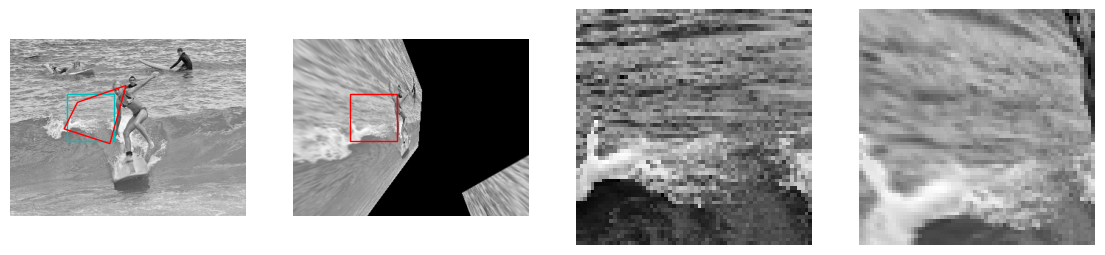

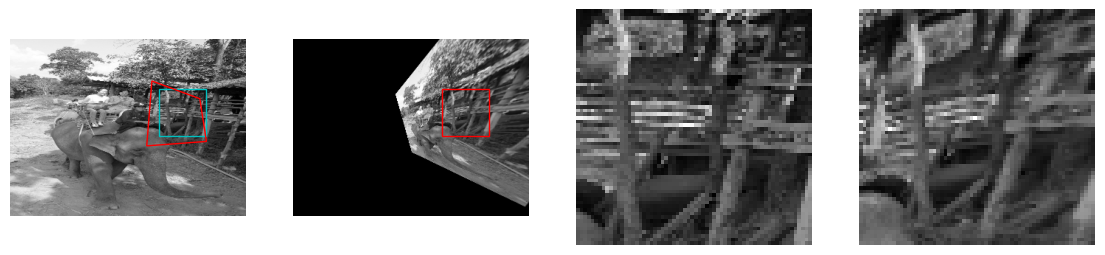

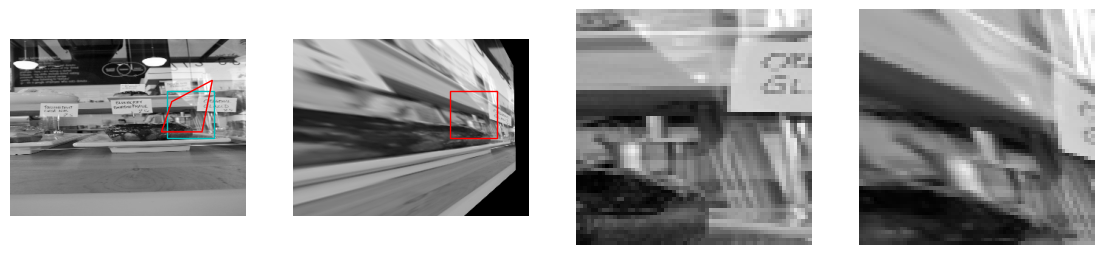

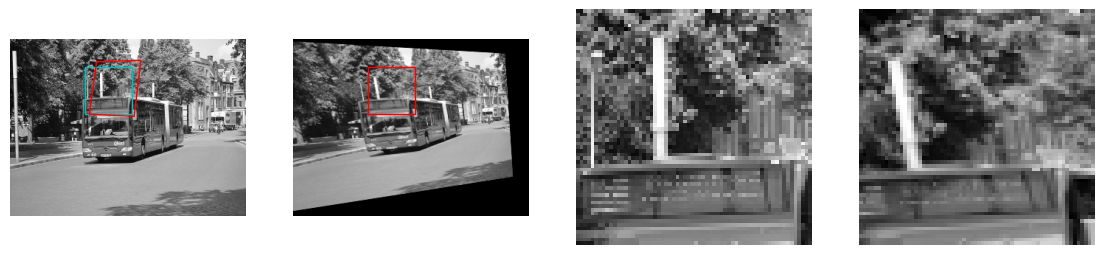

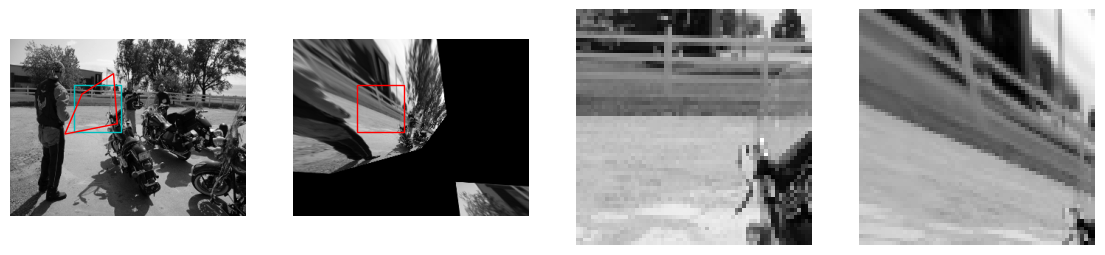

In [4]:
if __name__ == "__main__":

    number_of_pairs = 5
    data = generate_sample_pair("unlabeled2017/train", number_of_pairs)

    for i in range(len(data)):

        image_original, image_transformed, sample_original, sample_transformed, rect_original, rect_transformed = data[i]
    
        fig, ax = plt.subplots(1, 4, figsize=(14, 5))
        ax[0].imshow(image_original, cmap='gray')
        ax[0].add_patch(plt.Polygon(rect_original, fill=False, ec='c', lw=1.0))
        ax[0].add_patch(plt.Polygon(rect_transformed, fill=False, ec='r', lw=1.0))
        ax[0].set_axis_off()
    
        ax[1].imshow(image_transformed, cmap='gray')
        ax[1].add_patch(plt.Polygon(rect_original, fill=False, ec='r', lw=1.0))
        ax[1].set_axis_off()

        ax[2].imshow(sample_original, cmap='gray')
        ax[2].set_axis_off()
    
        ax[3].imshow(sample_transformed, cmap='gray')
        ax[3].set_axis_off()
    

In [5]:
def prepare_batch(dataset, batch_size, device, return_original_img):

    if (dataset == "train"):
        batch = generate_sample_pair("unlabeled2017/train", batch_size)
    else:
        batch = generate_sample_pair("unlabeled2017/test", batch_size)

    images = []
    labels = []

    for image in batch:
        images.append(np.stack((image[2], image[3])))
        labels.append(image[5] - image[4])

    images = torch.tensor(np.stack(images)).to(device).to(torch.float32)
    labels = torch.tensor(np.array(labels)).to(device).to(torch.float32)

    labels = labels.reshape(labels.shape[0], -1)

    if (return_original_img == True):
        return images, labels, batch[0][0], batch[0][2], batch[0][3], batch[0][4], batch[0][5]
    else:
        return images, labels

In [6]:
class ResnetBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # self.dropout1 = nn.Dropout2d()
        # self.dropout2 = nn.Dropout2d()
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.bn2(output)

        if (self.in_channels != self.out_channels):
            
            tmp = self.conv3(x)
            output += tmp

        output = self.relu2(output)
                            
        return output


class NetworkBody(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.resnet1 = ResnetBlock(2, 64)
        self.resnet2 = ResnetBlock(64, 64)
        self.resnet3 = ResnetBlock(64, 64)
        self.resnet4 = ResnetBlock(64, 64)
        self.resnet5 = ResnetBlock(64, 128)
        self.resnet6 = ResnetBlock(128, 128)
        self.resnet7 = ResnetBlock(128, 128)
        self.resnet8 = ResnetBlock(128, 128)

        self.mp1 = nn.MaxPool2d(2, stride=2)
        self.mp2 = nn.MaxPool2d(2, stride=2)
        self.mp3 = nn.MaxPool2d(2, stride=2)
        self.mp4 = nn.MaxPool2d(2, stride=2)

        self.flatten = nn.Flatten()
        
        self.linear = nn.Linear(8192, 512)
        
        self.dropout = nn.Dropout2d()

    def forward(self, x):

        output = self.resnet1(x)
        output = self.resnet2(output)
        output = self.mp1(output)
        output = self.resnet3(output)
        output = self.resnet4(output)
        output = self.mp2(output)
        output = self.resnet5(output)
        output = self.resnet6(output)
        output = self.mp3(output)
        output = self.resnet7(output)
        output = self.resnet8(output)
        
        output = output.view(output.size(0), -1)
        
        output = self.linear(output)
        output = self.dropout(output)

        return output


class RegressionNetwork(nn.Module): 

    def __init__(self):
        super().__init__()

        self.body = NetworkBody()
        
        self.linear = nn.Linear(512, 8)

    def forward(self, x):

        output = self.body(x)
        output = self.linear(output)

        return output


class ClassificationNetwork(nn.Module): 

    def __init__(self):
        super().__init__()

        self.body = NetworkBody()
        
        self.linear = nn.Linear(512, 168)

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(21, 8))

        self.softmax = nn.Softmax(2)

    def forward(self, x):

        output = self.body(x)
        output = self.linear(output)
        output = self.unflatten(output)
        output = self.softmax(output) # probably not needed during training

        return output

In [7]:
iterations = 1000
batch_size = 64
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = RegressionNetwork().to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 1e-4)

rmse = 0

steps_train = 0
steps_val = 0

for epoch in range(epochs):

    train_loss = 0
    val_loss = 0
    
    #train

    model.train()

    for iteration in range(iterations):
        
        images, labels = prepare_batch("train", batch_size, device, False)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss = torch.sqrt(loss)
    
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        loss_diagram.add_scalar("Loss/train/reg", loss.item(), steps_train)
        steps_train += 1
    
    print("Epoch: ", str(epoch + 1), " (training). Loss: ", train_loss / iterations)

    #validate

    with torch.no_grad():
        model.eval()

        for iteration in range(iterations):
        
            images, labels = prepare_batch("test", batch_size, device, False)
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss = torch.sqrt(loss)
    
            val_loss += loss.item()
            loss_diagram.add_scalar("Loss/test/reg", loss.item(), steps_val)
            steps_val += 1

    print("Epoch: ", str(epoch + 1), " (validating). Loss: ", val_loss / iterations)

    loss_diagram.flush()

cpu


D:\Anaconda\envs\rv\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch:  1  (training). Loss:  6.909787655353546
Epoch:  1  (validating). Loss:  5.919938869476319
Epoch:  2  (training). Loss:  4.872062776088715
Epoch:  2  (validating). Loss:  5.404953605175018
Epoch:  3  (training). Loss:  4.299711178064347
Epoch:  3  (validating). Loss:  4.078244333982467
Epoch:  4  (training). Loss:  3.9557264530658722
Epoch:  4  (validating). Loss:  4.423074427843094
Epoch:  5  (training). Loss:  3.7309486145973207
Epoch:  5  (validating). Loss:  3.402000452041626
Epoch:  6  (training). Loss:  3.5266425704956053
Epoch:  6  (validating). Loss:  4.636312288999558
Epoch:  7  (training). Loss:  3.3896031415462495
Epoch:  7  (validating). Loss:  3.4828896262645723
Epoch:  8  (training). Loss:  3.306520431280136
Epoch:  8  (validating). Loss:  4.374127434492111
Epoch:  9  (training). Loss:  3.1976447517871858
Epoch:  9  (validating). Loss:  3.383766654968262
Epoch:  10  (training). Loss:  3.098556091785431
Epoch:  10  (validating). Loss:  2.9667451214790344


In [8]:
torch.save(model, "save_regression.pt")

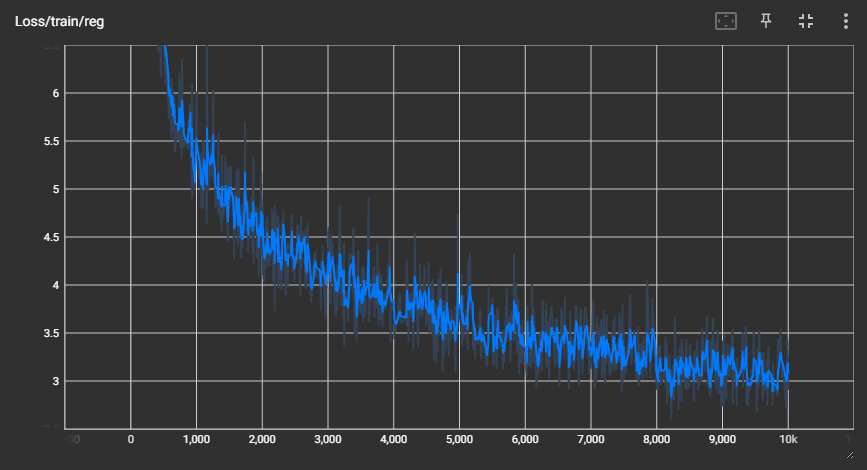

In [9]:
Image(filename='train-reg.png')

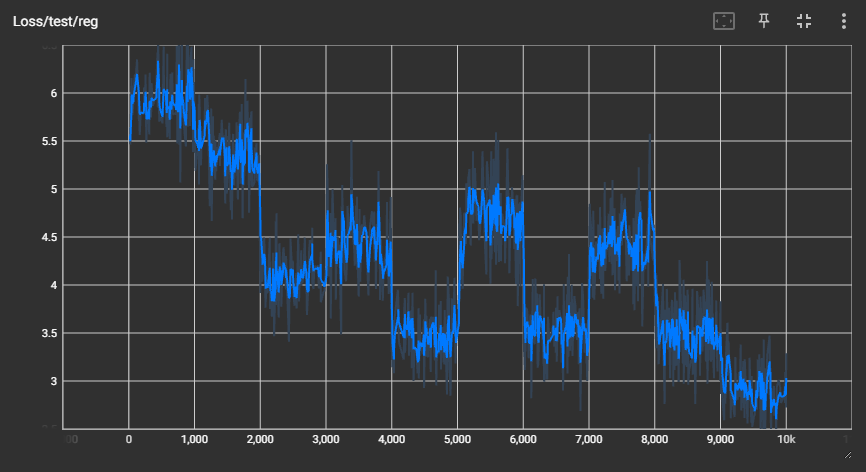

In [10]:
Image(filename='test-reg.png')

In [7]:
def normalize_to_classes(targets, min_val=-16, max_val=16, num_classes=8):
    # Scale continuous targets to the range [0, num_classes-1]
    scaled_targets = (targets - min_val) / (max_val - min_val) * (num_classes - 1)
    return scaled_targets.long()  # Convert to integer class indices

In [8]:
iterations = 1000
batch_size = 64
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ClassificationNetwork().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 1e-4)

rmse = 0

steps_train = 0
steps_val = 0

for epoch in range(epochs):

    train_loss = 0
    val_loss = 0
    
    #train

    model.train()

    for iteration in range(iterations):
        
        images, labels = prepare_batch("train", batch_size, device, False)
        # print(images)
        labels = normalize_to_classes(labels)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
    
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        loss_diagram.add_scalar("Loss/train/cla", loss.item(), steps_train)
        steps_train += 1
    
    print("Epoch: ", str(epoch + 1), " (training). Loss: ", train_loss / iterations)

    #validate

    with torch.no_grad():
        model.eval()

        for iteration in range(iterations):
        
            images, labels = prepare_batch("test", batch_size, device, False)

            labels = normalize_to_classes(labels)
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
    
            val_loss += loss.item()
            loss_diagram.add_scalar("Loss/test/cla", loss.item(), steps_val)
            steps_val += 1

    print("Epoch: ", str(epoch + 1), " (validating). Loss: ", val_loss / iterations)
    
    loss_diagram.flush()

cpu


D:\Anaconda\envs\rv\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch:  1  (training). Loss:  3.0246320412158965
Epoch:  1  (validating). Loss:  2.9906383213996888
Epoch:  2  (training). Loss:  2.954462488651276
Epoch:  2  (validating). Loss:  2.941173039674759
Epoch:  3  (training). Loss:  2.926532243490219
Epoch:  3  (validating). Loss:  2.934285517215729
Epoch:  4  (training). Loss:  2.9106517057418824
Epoch:  4  (validating). Loss:  2.9100558757781982
Epoch:  5  (training). Loss:  2.8997293989658357
Epoch:  5  (validating). Loss:  2.903969450235367
Epoch:  6  (training). Loss:  2.8887548949718473
Epoch:  6  (validating). Loss:  2.875980087041855
Epoch:  7  (training). Loss:  2.8773549208641054
Epoch:  7  (validating). Loss:  2.8652302672863006
Epoch:  8  (training). Loss:  2.865674062728882
Epoch:  8  (validating). Loss:  2.863949016332626
Epoch:  9  (training). Loss:  2.8568710038661957
Epoch:  9  (validating). Loss:  2.8537750144004823
Epoch:  10  (training). Loss:  2.8482779014110564
Epoch:  10  (validating). Loss:  2.8455451152324676


In [9]:
torch.save(model, "save_classification.pt")

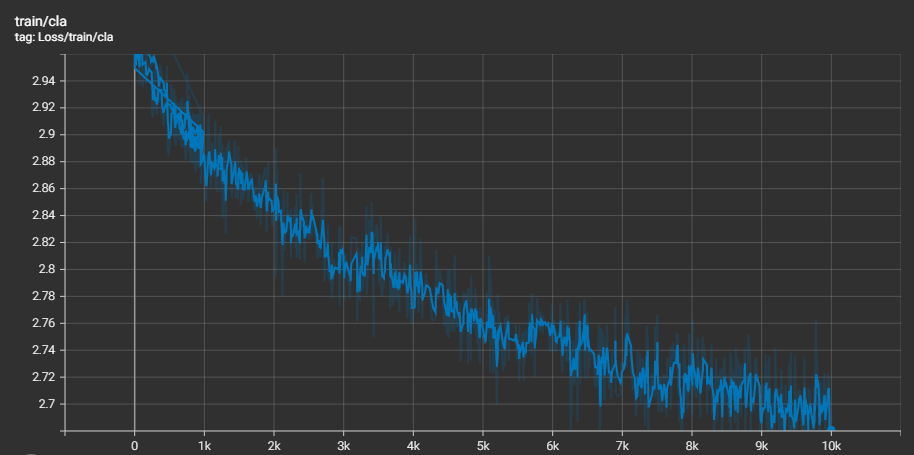

In [3]:
Image(filename='train-cla.png')

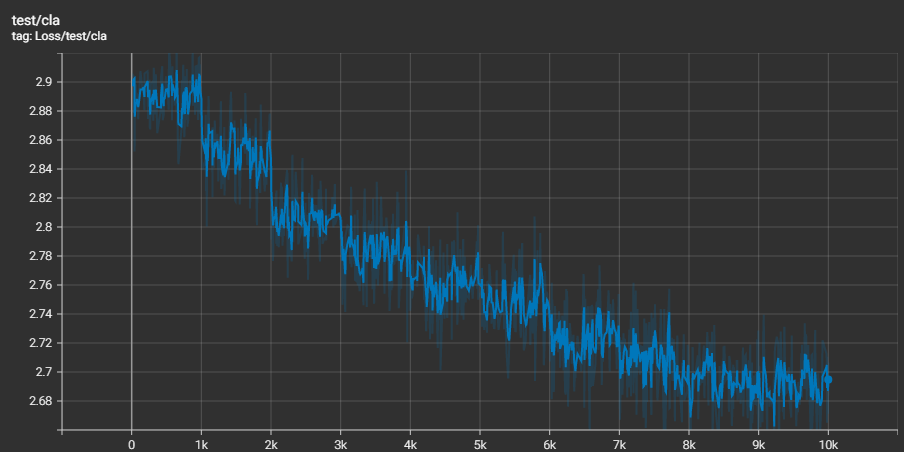

In [4]:
Image(filename='test-cla.png')

Text(0.5, 1.0, 'poravnan')

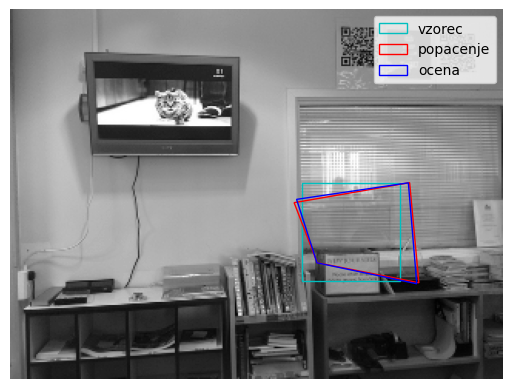

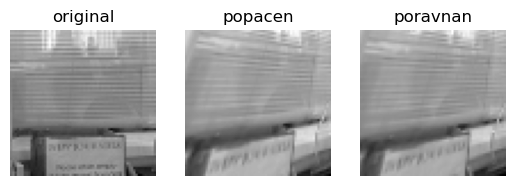

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

reg_model = torch.load("save_regression.pt", device)

images, labels, original_img, sample_original, sample_trans, rect, rect_prim = prepare_batch("test", 1, device, True)

prediction = reg_model(images)
new_rect = rect + prediction[0].detach().numpy().reshape(-1, 2)

fig, ax = plt.subplots(1, 1)
ax.imshow(original_img, cmap='gray')
ax.add_patch(plt.Polygon(rect, fill=False, ec='c', lw=1.0, label='vzorec'))
ax.add_patch(plt.Polygon(rect_prim, fill=False, ec='r', lw=1.0, label='popacenje'))
ax.add_patch(plt.Polygon(new_rect, fill=False, ec='b', lw=1.0, label='ocena'))
ax.set_axis_off()
plt.legend()

new_H, _ = cv2.findHomography(rect, new_rect)
new_H = np.linalg.inv(new_H)
new_warped = cv2.warpPerspective(original_img, new_H, (original_img.shape[1], original_img.shape[0]))

new_sample = new_warped[rect[0][1]:rect[0][1] + 64, rect[0][0]:rect[0][0]+64]

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].imshow(sample_original, cmap='gray')
ax[0].set_axis_off()
ax[0].set_title('original')
ax[1].imshow(sample_trans, cmap='gray')
ax[1].set_axis_off()
ax[1].set_title('popacen')
ax[2].imshow(new_sample, cmap='gray')
ax[2].set_axis_off()
ax[2].set_title('poravnan')

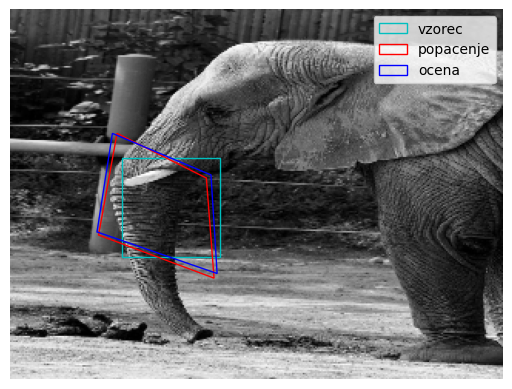

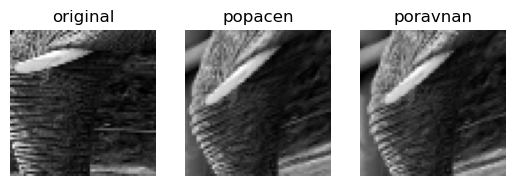

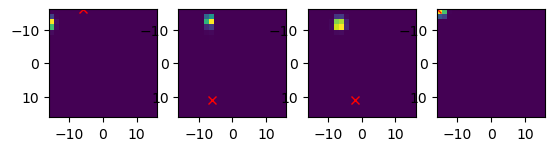

In [16]:
def denormalize_from_classes(normalized_values, min_val=-16, max_val=16, num_classes=8):
    
    normalized_values = normalized_values.T
    # print(normalized_values)
    
    output = []

    for i in normalized_values:
        
        max_j = 0
        
        for j in range(1, len(i)):
            if (i[j] > i[max_j]):
                max_j = j

        max_j = (max_j / (num_classes - 1)) * (max_val - min_val) + min_val
        output.append(int(max_j))
            
    return output


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_model = torch.load("save_classification_no_soft.pt", device)

images, labels, original_img, sample_original, sample_trans, rect, rect_prim = prepare_batch("test", 1, device, True)

prediction = class_model(images)
# prediction = torch.nn.Softmax(dim=1)(prediction)

prediction_offset = np.array(denormalize_from_classes(prediction[0].detach().numpy()))

new_rect = rect + prediction_offset.reshape(-1, 2)

fig, ax = plt.subplots(1, 1)
ax.imshow(original_img, cmap='gray')
ax.add_patch(plt.Polygon(rect, fill=False, ec='c', lw=1.0, label='vzorec'))
ax.add_patch(plt.Polygon(rect_prim, fill=False, ec='r', lw=1.0, label='popacenje'))
ax.add_patch(plt.Polygon(new_rect, fill=False, ec='b', lw=1.0, label='ocena'))
ax.set_axis_off()
plt.legend()

new_H, _ = cv2.findHomography(rect, new_rect)
new_H = np.linalg.inv(new_H)
new_warped = cv2.warpPerspective(original_img, new_H, (original_img.shape[1], original_img.shape[0]))

new_sample = new_warped[rect[0][1]:rect[0][1] + 64, rect[0][0]:rect[0][0]+64]

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].imshow(sample_original, cmap='gray')
ax[0].set_axis_off()
ax[0].set_title('original')
ax[1].imshow(sample_trans, cmap='gray')
ax[1].set_axis_off()
ax[1].set_title('popacen')
ax[2].imshow(new_sample, cmap='gray')
ax[2].set_axis_off()
ax[2].set_title('poravnan')

pred_maps = (prediction[:, :, ::2].reshape(-1, 21, 1, 4) * prediction[:, :, 1::2].reshape(-1, 1, 21, 4)).detach().numpy()
n = 0
fig, ax = plt.subplots(1, 4)
ax[0].imshow(pred_maps[n, :, :, 0], extent=(-16, 16, 16, -16))
ax[0].plot(prediction_offset[0], prediction_offset[1], 'rx')
ax[1].imshow(pred_maps[n, :, :, 1], extent=(-16, 16, 16, -16))
ax[1].plot(prediction_offset[2], prediction_offset[3], 'rx')
ax[2].imshow(pred_maps[n, :, :, 2], extent=(-16, 16, 16, -16))
ax[2].plot(prediction_offset[4], prediction_offset[5], 'rx')
ax[3].imshow(pred_maps[n, :, :, 3], extent=(-16, 16, 16, -16))
ax[3].plot(prediction_offset[6], prediction_offset[7], 'rx')